# Final Project Checkpoint 3

**Travis Tegen - Coursera MSCS 6300** </br>

In [1]:
""" RUN THIS CELL TO GET THE RIGHT FORMATTING """
import requests
from IPython.core.display import HTML
css_file = 'https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/css/cpsc6300.css'
styles = requests.get(css_file).text
HTML(styles)

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import mean_squared_error
from matplotcheck.base import PlotTester
from matplotlib.patches import PathPatch

import seaborn as sns

In [3]:
# Pull in the dataframe produced in Final Project Checkpoint 1
df = pd.read_csv("blossoms.csv")

# remove year because it is not a weather-related measurement, even though
# a year value certainly represents some weather patterns implicitly
df = df.drop(['year'], axis=1)

df.head()

,pbd,avg_tmp_prevdec,avg_tmp_jan,avg_tmp_feb,avg_tmp_mar,precip_prevdec,precip_jan,precip_feb,precip_mar,snow_prevdec,snow_jan,snow_feb,snow_mar,first_frost_to_jan1
0,79,39.3,36.6,39.0,55.5,3.15,2.30,2.29,2.76,0.2,1.8,7.10,0.05,50
1,97,37.9,31.9,38.7,45.3,1.95,5.56,2.86,4.74,5.5,31.5,3.00,6.50,52
2,99,37.6,36.8,32.6,45.3,3.48,4.24,2.19,4.47,1.8,3.1,3.90,6.70,40
3,104,45.0,35.0,34.3,42.6,2.80,3.21,3.05,6.17,1.7,1.0,5.30,9.30,60
4,86,36.5,32.9,43.1,46.4,2.98,4.44,0.98,1.60,0.5,19.7,0.05,0.05,46


### Alternate Models: Intro

As this course has covered, a simple linear regression model is a reasonable place to start when dealing with a continuous response variable and a dataset where there appears to be a linear relationship between some of the variables, and some linear relationships were observed in a correlation matrix in Checkpoint 2. To recap my explanation for choosing linear regression: it is a great model to try first with the data because as Lab 6 stated, it is a common baseline model, and "it's simple, fast, and easily interpretable."

To start Checkpoint 3, I will try out a couple alternative models and see how they compare to simple linear regression. This should clarify whether linear regression is actually the best choice for this problem. Additionally, since hyperparameters were out of the scope of the Checkpoint 2 assignment, I will try to find optimal hyperparameters for linear regression so that the comparison to the alternative models is more fair.

### Alternate Model 1: KNN

In Checkpoint 2, I mentioned KNN as a relevant model choice, but I didn't try it because I didn't think it would perform as well as simple linear regression. To begin alternate model exploration, I will train, fit, and optimize a KNN model to see how its performance compares to a simple linear regression model.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['pbd'], axis=1), df['pbd'], test_size=0.25, random_state=42)
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

model = KNeighborsRegressor(n_neighbors=2)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# gets the year values of of X_test
# test_pbd = df.loc[X_test.index]['year'].values

k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20]

y_train_pred = {}
y_test_pred = {}
results = []
for k in k_values:
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)        
    
    resid_train = abs(y_train - y_train_pred)
    res_mean_train = resid_train.mean()
    res_min_train = resid_train.min()
    res_max_train = resid_train.max()    
    
    resid_test = abs(y_test - y_test_pred)    
    res_mean_test = resid_test.mean()
    res_min_test = resid_test.min()
    res_max_test = resid_test.max()        
    
    results.append((k, train_r2, test_r2, mse_train, mse_test, res_mean_train, res_min_train, res_max_train, res_mean_test, res_min_test, res_max_test))    

results_df = pd.DataFrame(results, columns=['k', 'train_r2', 'test_r2', 'train_mse', 'test_mse', 'train_res_mean', 'train_res_min', 'train_res_max', 'test_res_mean', 'test_res_min', 'test_res_max'])
results_df

,k,train_r2,test_r2,train_mse,test_mse,train_res_mean,train_res_min,train_res_max,test_res_mean,test_res_min,test_res_max
0,1,1.000000,0.275394,0.000000,35.076923,0.000000,0.000000,0.000000,4.384615,0.000000,15.000000
1,2,0.728216,0.481970,16.128205,25.076923,3.102564,0.000000,13.500000,3.884615,0.500000,16.000000
2,3,0.666596,0.578108,19.784900,20.423077,3.431624,0.000000,13.000000,3.346154,0.000000,12.000000
3,4,0.596119,0.513950,23.967147,23.528846,3.875000,0.250000,13.000000,3.865385,0.250000,12.250000
4,5,0.592549,0.553096,24.178974,21.633846,3.858974,0.200000,11.800000,3.646154,0.200000,10.200000
5,6,0.533182,0.531827,27.701923,22.663462,4.194444,0.000000,12.666667,3.737179,0.333333,9.833333
6,7,0.465581,0.531263,31.713501,22.690738,4.456044,0.000000,14.000000,3.758242,0.142857,10.571429
7,8,0.434609,0.509580,33.551482,23.740385,4.616987,0.000000,14.625000,3.942308,0.875000,9.875000
8,9,0.412055,0.539539,34.889839,22.290123,4.763533,0.111111,14.777778,3.730769,0.555556,10.555556
9,10,0.406623,0.493372,35.212179,24.525000,4.837179,0.000000,14.000000,3.996154,0.700000,11.100000


Looking at the r-squared and mse scores on the test set suggests that around 4 is the ideal value of k to use for KNN with this dataset. Looking at the raw residuals of how many days off each of these KNN models' test set predictions were from the actual PBD, it appears that the best average number of days off is around 3.3, the best minimum days off are around 0 to 0.25, and the best maximum is pretty poor at about 9.8 days.

Below is a chart to compare the KNN performance above to the performance of the untuned simple linear regression model from Checkpoint 2.

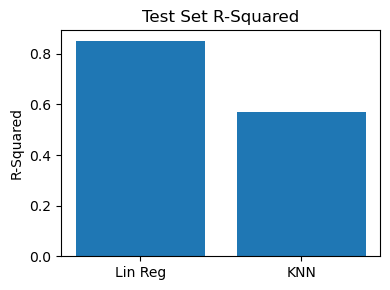

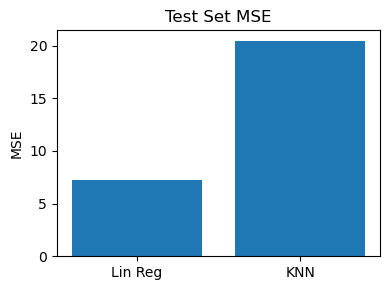

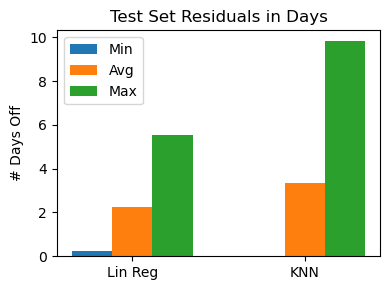

In [5]:
# ***Simple Linear Regression Performance***

# R^2: 0.8505881902735751
# MSE Test: 7.232769321727113

# Avg PBD residual (in days): 2.271122860224238
# Min PBD residual (in days): 0.26552275799127756
# Max PBD residual (in days): 5.557152740043406

# chart for r2
fig, ax = plt.subplots(figsize=(4, 3))
ax.bar([1,2], [0.85,0.57])
ax.set_ylabel('R-Squared')
ax.set_title('Test Set R-Squared')
ax.set_xticks([1,2], ['Lin Reg', 'KNN'])
fig.tight_layout()
plt.show()

# chart for MSE
fig, ax = plt.subplots(figsize=(4, 3))
ax.bar([1,2], [7.23,20.42])
ax.set_ylabel('MSE')
ax.set_title('Test Set MSE')
ax.set_xticks([1,2], ['Lin Reg', 'KNN'])
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(4, 3))
ax.bar([2-.35,3.15], [0.26,0], .35, label='Min')
ax.bar([2,3.5], [2.27,3.34], .35, label='Avg')
ax.bar([2.35,3.85], [5.55,9.83], .35, label='Max')
ax.set_ylabel('# Days Off')
ax.set_title('Test Set Residuals in Days')
ax.set_xticks([2,3.5], ['Lin Reg', 'KNN'])
ax.legend()
fig.tight_layout()
plt.show()

The analysis above indicates that simple linear regression provides more accurate predictions of PBD than KNN does, which supports the choice to start with linear regression instead of KNN in Checkpoint 2. It should be noted that KNN may have performed better with normalization of the features, but then again linear regression looks to have a pretty big lead over KNN. The only advantage KNN had over linear regression was it was able to get a minimum residual of 0 on some predictions, meaning it sometimes guessed the exact day. Linear regression was only .25 of a day off on it's best predictions though, which is good for this project's question of predicting a PBD calendar date.

### Alternate Model 2: FFNN

I also attempted a Feed Forward Neural Network since we learned about it in the last two weeks of lecture and labs. Initially, I thought there might be a chance FFNN could perform better than simple linear regression. I reasoned that a FFNN's ability to model a complex, curvy function in the feature space might enable it to outperform my simple linear model that is only modeling a linear function in the feature space.

However, after some simple testing I decided to abandon further exploration into FFNN for this project because its performance was so poor with the few sets of hyperparameters I tried. I suspect, as we have learned in lecture and in labs, the FFNN models are overfitting to the data whereas the simple linear regression model is generalizing better. We also learned in this course that FFNN is great for massive datasets. However, this project's Cherry Blossom dataset only has around 120 rows because it takes a whole year to be able to add another Peak Bloom Date to it. This particular failure helped me realize in a new way how simple linear regression is an excellent starting point for a base model.

In [6]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

print('Simple Linear Regression from Checkpoint 2 (no tuning)')
print('MSE on Test Set: 7.232769321727113')
print()

model = models.Sequential(name='MyNet')
model.add(layers.Dense(1, activation='relu'))
model.add(layers.Dense(1, activation='relu'))
model.add(layers.Dense(1, activation='linear'))
sgd = optimizers.SGD(learning_rate = 0.01)
model.compile(loss='MSE',optimizer=sgd)

history = model.fit(X_train, y_train, epochs=25, batch_size=3, verbose=0)
print("FFNN, 2 relu layers of 1 node, rate .01, 25 epochs")
print(f"BEST MSE: {min(history.history['loss'])}")
print()

model2 = models.Sequential(name='MyNet2')
model2.add(layers.Dense(5, activation='relu'))
model2.add(layers.Dense(5, activation='relu'))
model2.add(layers.Dense(1, activation='linear'))
sgd = optimizers.SGD(learning_rate = 0.02)
model2.compile(loss='MSE',optimizer=sgd)

history2 = model2.fit(X_train, y_train, epochs=100, batch_size=3, verbose=0)
print("FFNN, 2 relu layers of 5 nodes, rate .02, 100 epochs")
print(f"BEST MSE: {min(history2.history['loss'])}")

2025-04-14 03:02:54.066296: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Simple Linear Regression from Checkpoint 2 (no tuning)
MSE on Test Set: 7.232769321727113



2025-04-14 03:02:55.604155: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


FFNN, 2 relu layers of 1 node, rate .01, 25 epochs
BEST MSE: 59.52317428588867

FFNN, 2 relu layers of 5 nodes, rate .02, 100 epochs
BEST MSE: 59.564483642578125


### Tuning the Base Model

Utilizing cross validation has been covered in lecture and in labs as a means to improve a model's accuracy at predicting.

In [7]:
k_values = list(range(2, 8))

results_dict = {'k': [], 'Mean MSE': []}

for k_val in k_values:
    kf_var = KFold(n_splits=k_val, shuffle=True, random_state=42)
    
    scores_lr_var = cross_val_score(LinearRegression(), df.drop(['pbd'], axis=1), df['pbd'], cv=kf_var, scoring='neg_mean_squared_error')
    mse_lr_var = scores_lr_var
    mean_mse_lr = np.mean(mse_lr_var)
    results_dict['k'].append(k_val)
    results_dict['Mean MSE'].append(mean_mse_lr)

kfold_comparison_df = pd.DataFrame(results_dict)
kfold_comparison_df

,k,Mean MSE
0,2,-15.837852
1,3,-13.098815
2,4,-14.491729
3,5,-13.940572
4,6,-13.953015
5,7,-14.227298


It looks like the k value for CV doesn't have a significant affect the MSE score for the linear regression model. This might be because the dataset is so small.

Next, I will try removing some of the features that aren't correlated as strongly. It might remove noise and improve the model's predictions. I'll remove all features except for average temp of February and March, snowfall in March, and days first frost occurred before Jan 1.

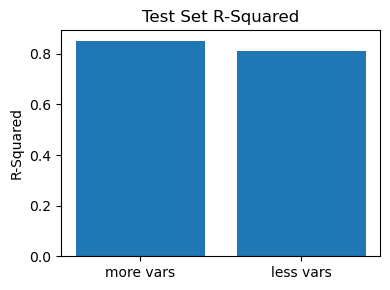

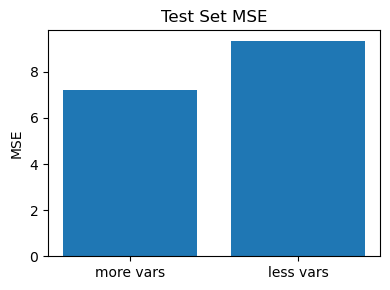

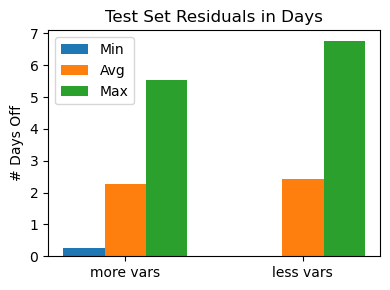

In [8]:
# X = df.drop(['pbd', 'avg_tmp_prevdec', 'avg_tmp_jan', 'precip_prevdec', 'precip_jan', 'precip_feb', 'precip_mar', 'snow_prevdec', 'snow_jan', 'snow_feb'], axis=1)
X = df.drop(['pbd', 'avg_tmp_prevdec', 'avg_tmp_jan', 'precip_prevdec', 'precip_jan', 'precip_feb', 'precip_mar', 'snow_prevdec', 'snow_jan', 'snow_feb'], axis=1)
y = df.pbd
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

regression = LinearRegression()
regression.fit(X_train, y_train)
r2 = regression.score(X_test, y_test)

predicted_y = regression.predict(X_test)

mse_train = mean_squared_error(y_train, regression.predict(X_train))
mse_test = mean_squared_error(y_test, predicted_y)

# ***Simple Linear Regression Performance***

# R^2: 0.8505881902735751
# MSE Test: 7.232769321727113

# Avg PBD residual (in days): 2.271122860224238
# Min PBD residual (in days): 0.26552275799127756
# Max PBD residual (in days): 5.557152740043406

# ***Simple Linear Regression Performance, less vars***

# R^2: 0.8072781669714112
# MSE Train: 14.724917182939816
# MSE Test: 9.329333230809972

# Avg PBD residual (in days): 2.4483182989869765
# Min PBD residual (in days): 0.0036605757069878564
# Max PBD residual (in days): 6.75845098669609

# chart for r2
fig, ax = plt.subplots(figsize=(4, 3))
ax.bar([1,2], [0.85,0.81])
ax.set_ylabel('R-Squared')
ax.set_title('Test Set R-Squared')
ax.set_xticks([1,2], ['more vars', 'less vars'])
fig.tight_layout()
plt.show()

# chart for MSE
fig, ax = plt.subplots(figsize=(4, 3))
ax.bar([1,2], [7.23,9.33])
ax.set_ylabel('MSE')
ax.set_title('Test Set MSE')
ax.set_xticks([1,2], ['more vars', 'less vars'])
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(4, 3))
ax.bar([2-.35,3.15], [0.26,.004], .35, label='Min')
ax.bar([2,3.5], [2.27,2.44], .35, label='Avg')
ax.bar([2.35,3.85], [5.55,6.76], .35, label='Max')
ax.set_ylabel('# Days Off')
ax.set_title('Test Set Residuals in Days')
ax.set_xticks([2,3.5], ['more vars', 'less vars'])
ax.legend()
fig.tight_layout()
plt.show()

It turns out that using only the highest correlating features actually makes the model perform slightly worse in R-Squared, MSE, and raw residuals. Although, similar to the KNN model earlier, this adjusted linear regression model's minimum raw residual is a little better. It would seem the base model is about as good as this project will get at answering the question of when the Peak Bloom date will occur.

To wrap up, I'll put the model to a real world test. When this project started, the Cherry Trees had not bloomed yet in 2025. Now, we know according to https://cherryblossomwatch.com/2025-cherry-blossoms that Peak Bloom of 2025 occurred on March 28th.

I'll manually add in the data for this year to the dataset, fit the model again, and then see what its prediction is for 2025.

In [9]:
df = pd.read_csv("blossoms-with-2025.csv")
df = df.drop(['year'], axis=1)

X = df.drop('pbd', axis=1)
y = df.pbd
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_2025 = X.tail(1)

regression = LinearRegression()
regression.fit(X_train, y_train)
predicted_y = regression.predict(X_2025)[0]
actual_y = df.tail(1).pbd.values[0]
days_off = actual_y - predicted_y

print('2025 Model Prediction')
print(f"Predicted: {predicted_y}; Actual: {actual_y}; Error: {days_off} days")

2025 Model Prediction
Predicted: 80.28440286400922; Actual: 87; Error: 6.715597135990777 days


The model's answer to this project's question "when will Peak Bloom date occur?" or more specifically in this scenario "when will Peak Bloom date occur in 2025?" is 80.3, which we will round to 80. This means the model predicts the 2025 PBD will occur on March 21st. Given the actual PBD was March 28th, the model's prediction for 2025 did not go well because at 6.7 days it is near the maximum raw residual that we measured in Checkpoint 2.